https://www.allesfitter.com/allesclass/retriving-data-and-models

## stellar parameters

## retrieving data and models

### gp

In [3]:
import os
import pickle
import gzip
from allesfitter import config as config_tess

datadir = './'
config_tess.init(datadir)
f = gzip.GzipFile(os.path.join(config_tess.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_tess = pickle.load(f)
f.close()

results_tess.keys(), len(results_tess)



allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2457139.1892
	shifted epoch: 2457721.7218
	shifted by 898 periods



! WARNING:
 elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
type: <class 'FutureWarning'>, file: /home/jp/github/research/transit/allesfitter/allesfitter/basement.py, line: 617


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [4]:
instruments = config_tess.BASEMENT.fulldata.keys()
instruments

dict_keys(['k2'])

In [5]:
results_tess['samples'].shape

(21295, 11)

In [6]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess)
posterior_samples_tess.shape

(21295, 11)

In [7]:
posterior_params_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess, as_type='dic') # all weighted posterior_samples
posterior_params_median_tess, posterior_params_ll_tess, posterior_params_ul_tess = general_output.get_params_from_samples(posterior_samples_tess)

In [8]:
import allesfitter
import numpy as np

#::: your settings
inst = 'k2' 
key = 'flux' 

#::: initialize the allesclass
af_tess = allesfitter.allesclass(datadir)

df = {}
df[inst] = {}

#::: load the data (and the correct error bars)
df[inst]['time'] = af_tess.data[inst]['time']
df[inst]['flux'] = af_tess.data[inst][key]
df[inst]['flux_err'] = af_tess.data[inst]['err_scales_'+key] * af_tess.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model


df[inst]['baseline'] = af_tess.get_posterior_median_baseline(inst, key)
df[inst]['model'] = af_tess.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df[inst]['detrended_flux'] = df[inst]['flux']-df[inst]['baseline']
df[inst]['residuals'] = df[inst]['flux']-(df[inst]['model']+df[inst]['baseline'])

#::: save everything to a file for your collaborators
# X = np.column_stack((time, flux, flux_err, detrended_flux, model, residuals))
# np.savetxt('my_final_file.csv', X, delimiter=',')




allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2457139.1892
	shifted epoch: 2457721.7218
	shifted by 898 periods


(0.995, 1.005)

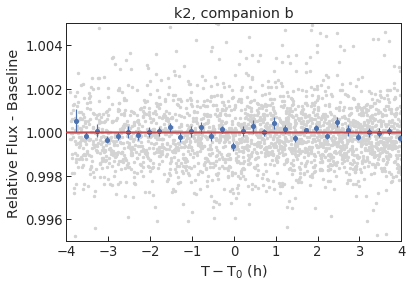

In [10]:
fig, ax = af_tess.plot(inst, 'b', 'phasezoom', Nsamples=50, force_binning=True)
ax.set_ylim(0.995,1.005)

Text(0.5, 0.98, 'EPIC 3752 c')

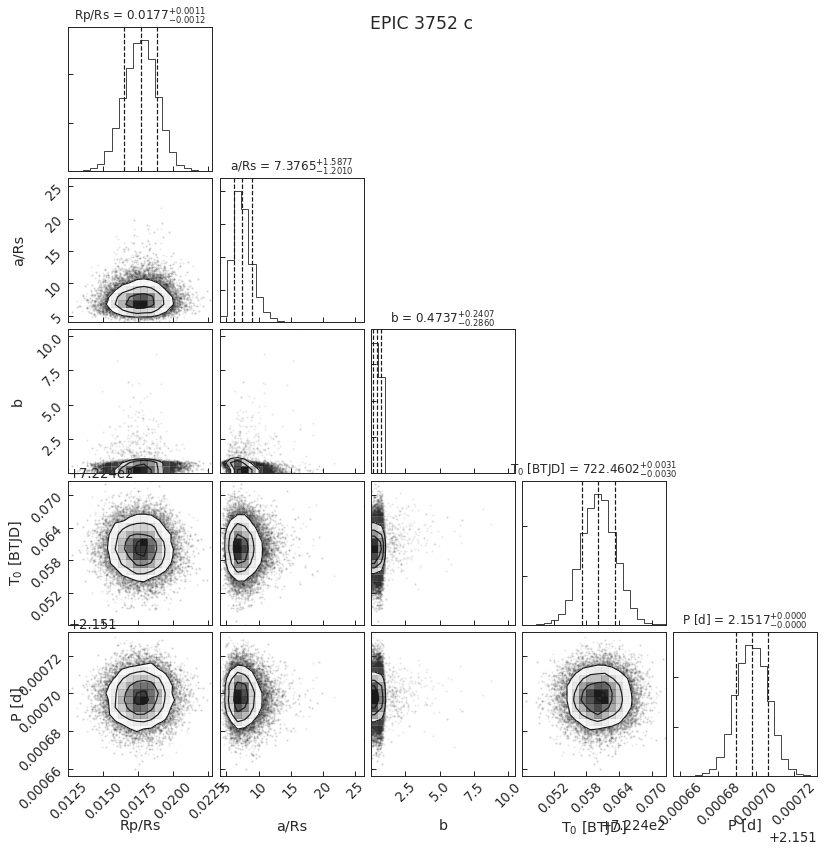

In [14]:
import corner
import pandas as pd

df_samples_tess = pd.DataFrame.from_dict(posterior_params_tess)
df_samples_tess.head()

planet = 'c'
df_samples_tess[f'{planet}_epoch'] = df_samples_tess[f'{planet}_epoch']-2457000

df_samples_tess['aRs'] = 1/df_samples_tess[f'{planet}_rsuma']
df_samples_tess['inc'] = np.rad2deg(np.arccos(df_samples_tess[f'{planet}_cosi']))
df_samples_tess['imp_par'] = df_samples_tess[f'{planet}_cosi']*df_samples_tess['aRs']

cols = [f'{planet}_rr', 'aRs', 'imp_par', f'{planet}_epoch', f'{planet}_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig1 = corner.corner(df_samples_tess[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig1.suptitle(f'EPIC 3752 {planet}')

In [15]:
df[inst]['posterior_samples'] = df_samples_tess

## save

In [16]:
df.keys()

dict_keys(['k2'])

In [18]:
import flammkuchen as dd

dd.save('./allesfit_transit_results_gp.h5', df)